<a href="https://colab.research.google.com/github/Xuan-He-97/Neural-networks-and-quantum-field-theory/blob/main/Experiments/Chapter2/2_5_N_scaling_of_Correlation_Functions_of_Fully_connected_networks_ReLU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import itertools
import pickle
import pathlib
import os
import numpy as np
import pandas as pd
from tensorflow.keras.layers import Dense, Layer
from tensorflow.keras import Model
from tensorflow.keras import initializers
import matplotlib.pyplot as plt
from scipy.special import erf
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from tqdm import tqdm
import time

### Introduction

To understand the scale of deviation from the ReLUProcess results of n-pt functions, we could compute connected piece of the n-pt functions.

- 2-pt function is exactly the kernel even away from GP (can be proved)

- $\Delta G^{(n)} \propto N^{-1}$ for $n = 4, 6$  (can be proved)

- connected contribution of the 4-pt function is same as $\Delta G^{(4)}$ $\propto N^{-1}$  (can be proved)

- connected contribution of the 6-pt function is $\propto N^{-2}$  (can be proved)

In theory,

- $G^{(2k)}(x_1, ..., x_{2k})|_{\text{connected}} = \left[ G^{(2k)}(x_1, ..., x_{2k}) - S(x_1, ..., x_{2k}) \right]|_{\text{internal indices same}}$

- $G^{(2k)}(x_1, ..., x_{2k})|_{\text{connected}} \propto \frac{1}{N^{k-1}}$


### Wick contraction

In [ ]:
def G_gp2(X, K):
    x1, x2 = X
    return K(x1, x2)

In [ ]:
def G_gp4(X, K):
    x1, x2, x3, x4 = X
    return K(x1, x2) * K(x3, x4) + K(x1, x3) * K(x2, x4) + K(x1, x4) * K(x2, x3)

In [ ]:
def G_gp6(X, K):
    wick_pairs = [[1, 2, 3, 4, 5, 6], [1, 2, 3, 5, 4, 6], [1, 2, 3, 6, 4, 5], [1, 3, 2, 4, 5, 6], [1, 3, 2, 5, 4, 6],
                  [1, 3, 2, 6, 4, 5], [1, 4, 2, 3, 5, 6], [1, 4, 2, 5, 3, 6], [1, 4, 2, 6, 3, 5], 
                  [1, 5, 2, 3, 4, 6], [1, 5, 2, 4, 3, 6],
                  [1, 5, 2, 6, 3, 4], [1, 6, 2, 3, 4, 5], [1, 6, 2, 4, 3, 5], [1, 6, 2, 5, 3, 4]]
    res = 0
    for x1, x2, x3, x4, x5, x6 in wick_pairs:
        res += K(X[x1-1], X[x2-1]) * K(X[x3-1], X[x4-1]) * K(X[x5-1], X[x6-1])
    return res

### Input of each network

In [ ]:
X_ReLU = np.array([[0.2], [0.4], [0.6], [0.8], [1.0], [1.2]])

In [ ]:
Ns = [2, 3, 4, 5, 10, 20, 50, 100, 500, 1000]

### Save variables to google drive

In [ ]:
from google.colab import drive
# log in to the google drive account
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


### Find all distinct combination of $G^{(n)}$

In [ ]:
def findsubsets(X, n):
    res = []
    for i1 in range(n+1):
        for i2 in range(n+1-i1):
            for i3 in range(n+1-i1-i2):
                for i4 in range(n+1-i1-i2-i3):
                    for i5 in range(n+1-i1-i2-i3-i4):
                        i6 = n-i1-i2-i3-i4-i5
                        res.append([X[0]]*i1 + [X[1]]*i2 + [X[2]]*i3 + [X[3]]*i4 + [X[4]]*i5 + [X[5]]*i6)
    return res

In [ ]:
comb2 = findsubsets([i for i in range(6)], 2)
print(len(comb2))
comb4 = findsubsets([i for i in range(6)], 4)
print(len(comb4))
comb6 = findsubsets([i for i in range(6)], 6)
print(len(comb6))

21
126
462


### n-pt function

In [ ]:
def npt(Y, comb):
    corr_function = []
    for c in comb:
        corr_function.append(Y[:, :, c].prod(2).mean(1))
    
    return np.array(corr_function).T # shape = len(comb)

### Connected part of n-pt function

Connected part of n-pt function is obtained by the following equation.

\begin{aligned}
&\left.G^{(6)}\left(x_{1}, x_{2}, x_{3}, x_{4}, x_{5}, x_{6}\right)\right|_{\text {connected }}=G^{(6)}\left(x_{1}, x_{2}, x_{3}, x_{4}, x_{5}, x_{6}\right)-\sum_{\mathcal{P}(a b c d e f)} \\
&\left(G^{(4)}\left(x_{a}, x_{b}, x_{c}, x_{d}\right) G^{(2)}\left(x_{e}, x_{f}\right)-2 \cdot G^{(2)}\left(x_{a}, x_{b}\right) G^{(2)}\left(x_{c}, x_{d}\right) G^{(2)}\left(x_{e}, x_{f}\right)\right)
\end{aligned}

In [ ]:
def G_6_connected(Y, comb):
    
    #print()
    start_time = time.time()
    res = npt(Y, comb) # get G^(6) correlation
    end_time = time.time()
    #print('Complete computing G6 function. Time: ', end_time - start_time) # show time consuming
    
    
    G6 = res.copy() # (100, 462)
    comb = np.array(comb)
    
    # wick combinations of G^(4)*G^(2)
    wick_pairs24 = [[1, 2, 3, 4, 5, 6], [1, 3, 2, 4, 5, 6], [1, 4, 2, 3, 5, 6], [1, 5, 2, 3, 4, 6], [1, 6, 2, 3, 4, 5], 
                    [2, 3, 1, 4, 5, 6], [2, 4, 1, 3, 5, 6], [2, 5, 1, 3, 4, 6], [2, 6, 1, 3, 4, 5], [3, 4, 1, 2, 5, 6], 
                    [3, 5, 1, 2, 4, 6], [3, 6, 1, 2, 4, 5], [4, 5, 1, 2, 3, 6], [4, 6, 1, 2, 3, 5], [5, 6, 1, 2, 3, 4]]
    
    G2s, G4s = [], []
    # Compute G4*G2 contribution
    start_time = time.time()
    for x in wick_pairs24:
        x = [i-1 for i in x] # convert x to list of indices
        G2 = npt2[[tuple(i) for i in comb[:, x[:2]]]].values # get 2-pt function, the size of G2 is (100, 462)
        G4 = npt4[[tuple(i) for i in comb[:, x[2:]]]].values # get 4-pt function, the size of G4 is (100, 462)
        G2s.append(G2)
        G4s.append(G4)
        res -= G4 * G2
    G2s, G4s = np.array(G2s), np.array(G4s)  # (15, 100, 462)
    end_time = time.time()
    #print('Complete computing G4*G2 function. Time: ', end_time - start_time) # show time consuming

    # wick combinations of G^(2)*G^(2)*G^(2)
    wick_pairs222 = [[1, 2, 3, 4, 5, 6], [1, 2, 3, 5, 4, 6], [1, 2, 3, 6, 4, 5], [1, 3, 2, 4, 5, 6], [1, 3, 2, 5, 4, 6], [1, 3, 2, 6, 4, 5]
                     , [1, 4, 2, 3, 5, 6], [1, 4, 2, 5, 3, 6], [1, 4, 2, 6, 3, 5], [1, 5, 2, 3, 4, 6], [1, 5, 2, 4, 3, 6], 
                     [1, 5, 2, 6, 3, 4], [1, 6, 2, 3, 4, 5], [1, 6, 2, 4, 3, 5], [1, 6, 2, 5, 3, 4]]
    start_time = time.time()
    for x in wick_pairs222:
        x = [i-1 for i in x]  # convert x to list of indices
        res += 2 * npt2[[tuple(i) for i in comb[:, x[:2]]]].values * npt2[[tuple(i) for i in comb[:, x[2:4]]]].values * npt2[[tuple(i) for i in comb[:, x[4:]]]].values 

    end_time = time.time()
    #print('Complete computing G2*G2*G2 function. Time: ', end_time - start_time) # show time consuming
    #print()
    return res, G6, G2s, G4s

In [ ]:
# Load experiment results
fx_exps = []
for N in Ns:
    with open('/gdrive/MyDrive/NNGP/ReLU/fx_exp_' + str(N) + '.pickle', 'rb') as handle:
        fx_exp = pickle.load(handle)
        fx_exps.append(fx_exp)

In [ ]:
%%time
connected_list, G6_list, G2s_list, G4s_list = [], [], [], []
for fx_exp in tqdm(fx_exps):
    # Compute 2-pt function
    npt2 = npt(fx_exp, comb2)
    npt2 = pd.DataFrame(npt2, columns=[tuple(i) for i in comb2])
    # Compute 4-pt function
    npt4 = npt(fx_exp, comb4)
    npt4 = pd.DataFrame(npt4, columns=[tuple(i) for i in comb4])
    
    # Compute 6-pt function and save the intermediate results
    connected, G6, G2s, G4s = G_6_connected(fx_exp, comb6)
    connected_list.append(connected)
    G6_list.append(G6)
    G2s_list.append(G2s)
    G4s_list.append(G4s)



  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [04:00<36:02, 240.23s/it]

 20%|██        | 2/10 [07:59<31:59, 239.95s/it]

 30%|███       | 3/10 [12:05<28:11, 241.69s/it]

 40%|████      | 4/10 [16:03<24:03, 240.57s/it]

 50%|█████     | 5/10 [21:11<21:43, 260.78s/it]

 60%|██████    | 6/10 [25:58<17:54, 268.64s/it]

 70%|███████   | 7/10 [30:20<13:19, 266.66s/it]

 80%|████████  | 8/10 [35:04<09:03, 271.91s/it]

 90%|█████████ | 9/10 [39:48<04:35, 275.49s/it]

100%|██████████| 10/10 [44:19<00:00, 265.96s/it]

CPU times: user 44min 10s, sys: 28.9 s, total: 44min 39s
Wall time: 44min 19s


### Background of the connected part

The error in the connected 6-pt functions is the combination of 6-pt error and 4-pt error.

$$
\left.\delta G^{(6)}\right|_{\text {connected }}=\sqrt{\left(\delta G^{(6)}\right)^{2}+\left(G^{(2)} \delta G^{(4)}\right)^2} .
$$

In [ ]:
bk_list = []
for i in tqdm(range(len(fx_exps))):
    bk = np.sqrt(np.square(G6_list[i].std(0)) + (np.square(G4s_list[i].std(1)) * np.square(G2s_list[i].mean(1))).sum(0))
    bk_list.append(bk)



  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:00<00:00, 61.15it/s]


### Compute $G^{(6)}_{GP}$ value

The connected part of 6-pt function is normalized by GP 6-pt function.

In [ ]:
comb6_ReLU = findsubsets(X_ReLU.reshape(-1), 6) # Combination of different x
print(len(comb6_ReLU))

462


In [ ]:
def K_ReLU(x, y, sigmab2=0.0, sigmaw2=1.0, d_in=1.0):
    xy = x * y
    xx = x * x
    yy = y * y
    corr = np.sqrt((sigmab2 + sigmaw2*xx/d_in) * (sigmab2 + sigmaw2*yy/d_in))
    costheta = (sigmab2 + sigmaw2*xy/d_in) / corr
    theta = np.arccos(costheta)
    return sigmab2 + sigmaw2 * (1.0 / (2.0*np.pi)) * corr * (np.sin(theta) + (np.pi - theta) * costheta)

In [ ]:
pt6_gp_ReLU = []
for c in comb6_ReLU:
    pt6_gp_ReLU.append(G_gp6(c, K_ReLU))

pt6_gp_ReLU = np.array(pt6_gp_ReLU)

### Plot Connected part

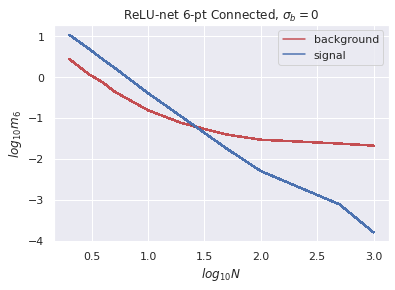

In [ ]:
# The connected part of the 6-pt functions. Average over 100 experiments and normalized by the GP 6-pt function.
mean_df = pd.DataFrame(np.log10(np.abs(np.array(connected_list).mean(1)) / pt6_gp_ReLU), columns=['signal']*connected_list[0].shape[-1])
# The background of the connected part, normalized by the GP 6-pt function.
std_df = pd.DataFrame(np.log10(bk_list / pt6_gp_ReLU), columns=['background']*connected_list[0].shape[-1])
colors = ['r']*connected_list[0].shape[-1] + ['b']*connected_list[0].shape[-1]
concated_df = pd.concat([std_df, mean_df], axis=1)
concated_df.index = [np.log10(N) for N in Ns]
ax = concated_df.plot(color=colors, legend=False)

lines, labels = ax.get_legend_handles_labels()
ax.legend([lines[0], lines[-1]], [labels[0], labels[-1]], loc='best')
plt.xlabel("$log_{10}N$")
plt.ylabel("$log_{10}m_6$")
plt.title("ReLU-net 6-pt Connected, $\sigma_b=0$")
plt.show() 

#### Fit the signal

The signal is linearly decreasing when $N < 100$. Fit this part of signal and add its plot on the previous graph.

In [ ]:
x = np.log10(Ns[:-2])
y = np.log10(np.array(connected_list[:-2]).mean(1) / pt6_gp_ReLU).mean(1)
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
xp = x

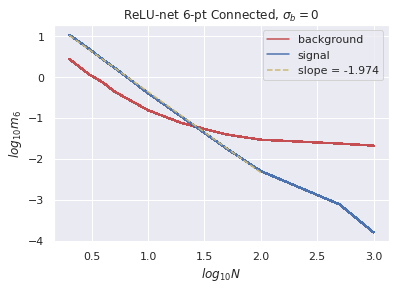

In [ ]:
mean_df = pd.DataFrame(np.log10(np.abs(np.array(connected_list).mean(1)) / pt6_gp_ReLU), columns=['signal']*connected_list[0].shape[-1])
std_df = pd.DataFrame(np.log10(bk_list / pt6_gp_ReLU), columns=['background']*connected_list[0].shape[-1])
colors = ['r']*connected_list[0].shape[-1] + ['b']*connected_list[0].shape[-1]
concated_df = pd.concat([std_df, mean_df], axis=1)
concated_df.index = [np.log10(N) for N in Ns]
ax = concated_df.plot(color=colors, legend=False)
# Linear fit line
line = ax.plot(xp, p(xp), '--', label='slope = ' + str(round(z[0], 3)), c='y')
lines, labels = ax.get_legend_handles_labels()
ax.legend([lines[0], lines[-2], lines[-1]], [labels[0], labels[-2], labels[-1]], loc='best')
plt.xlabel("$log_{10}N$")
plt.ylabel("$log_{10}m_6$")
plt.title("ReLU-net 6-pt Connected, $\sigma_b=0$")
plt.show() 